# Custom notebook: download original and derived star photometry 

**Learning tabective:** Create 2 tables of LSST tabects: one for galaxies, one for stars

**LSST data products:** `tabect` table

**Packages:** `lsst.rsp.get_tap_service`

## 1. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lsst.geom as geom

from lsst.rsp import get_tap_service
from lsst.rsp.utils import get_pyvo_auth
from lsst.rsp.service import get_siav2_service

from rubin_sim.phot_utils import DustValues

In [2]:
service = get_tap_service("tap")
assert service is not None

In [3]:
# os.environ['RUBIN_SIM_DATA_DIR'] = '/rubin/rubin_sim_data'

## 2. ECDFS

### 2.1 Set target

In [4]:
target_ra = 53.195
target_dec = -27.703
target_r = 5

We won't take into account the AGNs (present in the DIAtabect catalog). We will only look at galaxies and stars in the tabect catalog. To differentiate them efficiently within the LSST catalog, we establish a selection criterion : if 3 bands or more show {band}_extendedness = 1, we'll consider it as a galaxies. Unless the sources will be flagged as stars. But that something that will be useful later.

### 2.2 Query

In [27]:
query = "SELECT objectId, coord_ra, coord_dec, ebv, " + \
        "u_psfMag, u_psfMagErr, " + \
        "g_psfMag, g_psfMagErr, " + \
        "r_psfMag, r_psfMagErr, " + \
        "i_psfMag, i_psfMagErr, " + \
        "z_psfMag, z_psfMagErr, " + \
        "y_psfMag, y_psfMagErr " + \
        "FROM dp1.Object AS obj " + \
        "WHERE (r_psfFlux/r_psfFluxErr > 10) AND " + \
        "(shape_flag = 0) AND " + \
        "(g_extendedness = 0) AND " + \
        "(r_extendedness = 0) AND " + \
        "(i_extendedness = 0) AND " + \
        "(z_extendedness = 0) AND " + \
        "CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS',"+str(target_ra)+","+str(target_dec)+", "+str(target_r)+")) = 1 "



In [28]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [29]:
results = job.fetch_result()
tab = results.to_table()
tab

objectId,coord_ra,coord_dec,ebv,u_psfMag,u_psfMagErr,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,i_psfMag,i_psfMagErr,z_psfMag,z_psfMagErr,y_psfMag,y_psfMagErr,g_cModelMag,g_cModelMagErr
,deg,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
609780902427367304,52.71829196911317,-28.589980150794716,0.00887024,25.7493,1.03479,21.9573,0.0121833,20.6564,0.00671125,19.4467,0.00195384,18.9176,0.00289221,--,--,21.9603,0.0124592
609780902427366930,52.68001791949188,-28.615168079594536,0.00908367,--,--,21.042,0.0111965,19.7313,0.00352399,18.396,0.00148751,17.817,0.00332322,--,--,21.0434,0.0117902
609780902427366900,52.707752678471756,-28.616870166440137,0.00913003,--,--,17.9383,0.00118795,17.4368,0.00130145,17.2449,0.000680112,17.1707,0.00109271,--,--,17.9406,0.00123301
609780902427367138,52.68439814188332,-28.59995181184464,0.00897914,--,--,19.2523,0.00263358,18.7556,0.00194993,17.673,0.00105245,17.127,0.00210032,--,--,19.2587,0.00275674
609780833707898110,52.72333263458438,-28.61295266270727,0.00905877,--,--,19.2632,0.00238291,18.8412,0.00276501,18.6735,0.00134922,18.6115,0.0025685,--,--,19.2631,0.00245356
609780902427366779,52.708826957166565,-28.62575142657601,0.00923813,--,--,23.3534,0.0742117,22.4681,0.0452028,21.8904,0.025126,21.7186,0.0425262,--,--,23.3534,0.0752061
611257134226611158,53.110662064112546,-27.50640767355987,0.00937863,24.1853,0.463196,23.1119,0.0239676,21.9762,0.0259278,20.9617,0.00941486,20.5251,0.00897342,--,--,23.1198,0.0243154
611257134226610698,53.12507007884748,-27.517198072366266,0.0093728,22.5415,0.104741,20.0887,0.00204055,18.7331,0.00278834,17.8096,0.00102842,17.4093,0.000820718,--,--,20.0911,0.00206825


### 2.3 Apply dust correction and SDSS color conversion

In [8]:
os.environ['RUBIN_SIM_DATA_DIR'] = '/rubin/rubin_sim_data'

In [9]:
bands = "ugri"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.titlesize"] = 15
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.titlesize"] = 12

Apply dust correction

In [10]:
R_band = DustValues().r_x

In [11]:
A_band = {band: R_band[band] * tab['ebv'] for band in bands}

In [12]:
for band in bands:
    tab[f"{band}_psfMag0"] = tab[f"{band}_psfMag"] - A_band[band]

Transform the dust-corrected photometry to the SDSS system, following the equations from [RTN-099](https://rtn-099.lsst.io/).

In [13]:
tab["ug"] = tab["u_psfMag0"] - tab["g_psfMag0"]
tab["gr"] = tab["g_psfMag0"] - tab["r_psfMag0"]
tab["gi"] = tab["g_psfMag0"] - tab["i_psfMag0"]
tab["ri"] = tab["r_psfMag0"] - tab["i_psfMag0"]

tab["gi_sdss"] = 1.065*tab["gi"] + 0.005
tab["gr_sdss"] = 1.058*tab["gr"] + 0.058*tab["gr"] - 0.002
tab["u_sdss"] = tab["u_psfMag0"] + 0.063*tab["gi"] **2 - 0.192*tab["gi"] + 0.263

In [14]:
g_cri = (tab["g_psfMag0"] > 14) & (tab["g_psfMag0"] < 24)
gr_cri = (tab["gr"] > 0) & (tab["gr"] < 1)
ug_gr_cri = ((tab["ug"] > 0.5) & (tab["ug"] < 2.0) &
             (tab["gr"] - 0.5 * tab["ug"] > -0.5) & (tab["gr"] - 0.5 * tab["ug"] < 0.1))
gr_ri_cri = (0.35*tab["gr"] - tab["ri"] > -0.5) & (0.35*tab["gr"] - tab["ri"] < 0.5)

In [15]:
sel = (A_band["r"] < 0.5) & g_cri & gr_cri & ug_gr_cri & gr_ri_cri
print(f"There are {len(tab[sel])} stars suitable for this analysis.")

There are 943 stars suitable for this analysis.


### 2.4 Derive stellar parameters (Teff and [Fe/H])

Teff

In [16]:
from astropy.table import MaskedColumn

tab['log_teff'] = MaskedColumn(np.zeros(len(tab)), mask=np.ones(len(tab), dtype=bool))

tab['log_teff'][sel] = 3.872 - 0.264 * tab['gr_sdss'][sel]
tab['log_teff'].mask[sel] = False

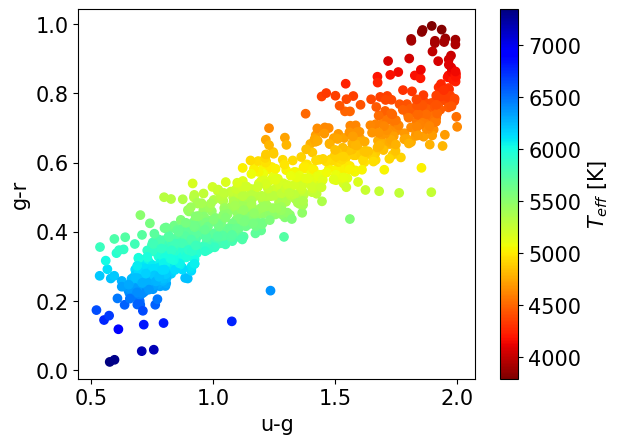

In [17]:
plt.scatter(np.ma.filled(tab["ug"], np.nan), np.ma.filled(tab["gr"], np.nan),
            c=10**np.ma.filled(tab["log_teff"], np.nan), cmap=plt.cm.jet_r)
plt.xlabel('u-g')
plt.ylabel('g-r')
cb = plt.colorbar()
cb.set_label(r'$T_{eff}$ [K]')

[Fe/H]

In [18]:
def feh_phot_ivezic2008(u_minus_g, g_minus_r):
    """
    Compute photometric metallicity [Fe/H]_ph from SDSS colors using the
    calibration of Ivezić et al. (2008, ApJ, 684, 287; Eq. 4).

    This empirical relation estimates stellar metallicity for F/G-type
    main-sequence stars based on their (u–g) and (g–r) colors.

    Parameters
    ----------
    u_minus_g : array_like
        The (u–g) color(s) of the star(s).
    g_minus_r : array_like
        The (g–r) color(s) of the star(s).

    Returns
    -------
    feh : ndarray
        Photometric metallicity [Fe/H]_ph, in dex.
    """
    ug = np.asarray(u_minus_g, dtype=float)
    gr = np.asarray(g_minus_r, dtype=float)

    x = np.where(gr <= 0.4, ug, ug - 2.0*gr + 0.8)
    y = gr

    a, b, c, d, e, f, g, h, i, j = (
        -4.37, -8.56, 15.5, -39.0, 23.5, 20.5, 12.1, 7.33, -10.1, -21.4
    )

    feh = (a + b*x + c*y + d*x*y + e*x**2 + f*y**2
             + g*x**2*y + h*x*y**2 + i*x**3 + j*y**3)

    return feh

In [19]:
tab['feh'] = MaskedColumn(np.zeros(len(tab)), mask=np.ones(len(tab), dtype=bool))
tab['feh'][sel] = feh_phot_ivezic2008(tab['ug'][sel], tab['gr'][sel])
tab['feh'].mask[sel] = False
fehtest = feh_phot_ivezic2008(tab['ug'][sel], tab['gr'][sel])
tab['feh'][sel] 

-0.5864961644227562
-0.773953956069394
-2.8697251036221445
-0.7026816140055867
-0.9022783173234583
-0.6291024043575604
-0.4989566320753587
-0.6243060737875452
-1.735526995162104
-0.8490683729206361
-1.195508553565495


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


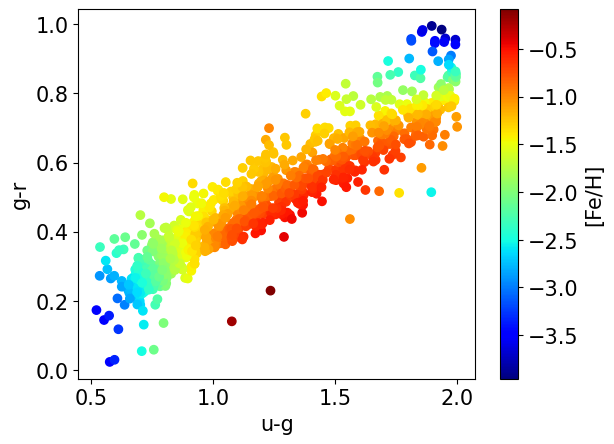

In [20]:
plt.scatter(tab["ug"], tab["gr"], c=tab['feh'], cmap=plt.cm.jet)
plt.xlabel('u-g')
plt.ylabel('g-r')
cb = plt.colorbar()
cb.set_label('[Fe/H]')

### 2.5 Save resulting table with derived columns

Save table

In [21]:
tab.write('DP1_ECDFS_star_photometry.csv', format='csv', overwrite=True)


In [30]:
job.delete()
del query, results, tab

### 2.6 Including galaxies

In [15]:
query = "SELECT objectId, coord_ra, coord_dec, ebv, " + \
        "u_cModelMag, u_cModelMagErr, " + \
        "g_cModelMag, g_cModelMagErr, " + \
        "r_cModelMag, r_cModelMagErr, " + \
        "i_cModelMag, i_cModelMagErr, " + \
        "z_cModelMag, z_cModelMagErr, " + \
        "y_cModelMag, y_cModelMagErr, " + \
        "u_psfMag, u_psfMagErr, " + \
        "g_psfMag, g_psfMagErr, " + \
        "r_psfMag, r_psfMagErr, " + \
        "i_psfMag, i_psfMagErr, " + \
        "z_psfMag, z_psfMagErr, " + \
        "y_psfMag, y_psfMagErr, " + \
        "u_Extendedness " + \
        "g_Extendedness " + \
        "r_Extendedness " + \
        "i_Extendedness " + \
        "z_Extendedness " + \
        "y_Extendedness " + \
        "refExtendedness " + \
        "FROM dp1.Object AS obj " + \
        "WHERE (r_cModelFlux/r_cModelFluxErr > 1) AND " + \
        "(shape_flag = 0) AND " + \
        "CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS',"+str(target_ra)+","+str(target_dec)+", "+str(target_r)+")) = 1 "



In [16]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [17]:
results = job.fetch_result()
tab = results.to_table()

In [18]:
tab.write('DP1_ECDFS_photometry.csv', format='csv', overwrite=True)

In [19]:
job.delete()
del query, results, tab